Epoch [1000/10000], Loss: 9.2676
Epoch [2000/10000], Loss: 9.0461
Epoch [3000/10000], Loss: 9.5652
Epoch [4000/10000], Loss: 8.9606
Epoch [5000/10000], Loss: 8.5259
Epoch [6000/10000], Loss: 9.3343
Epoch [7000/10000], Loss: 8.4583
Epoch [8000/10000], Loss: 8.7585
Epoch [9000/10000], Loss: 8.7491
Epoch [10000/10000], Loss: 8.7253


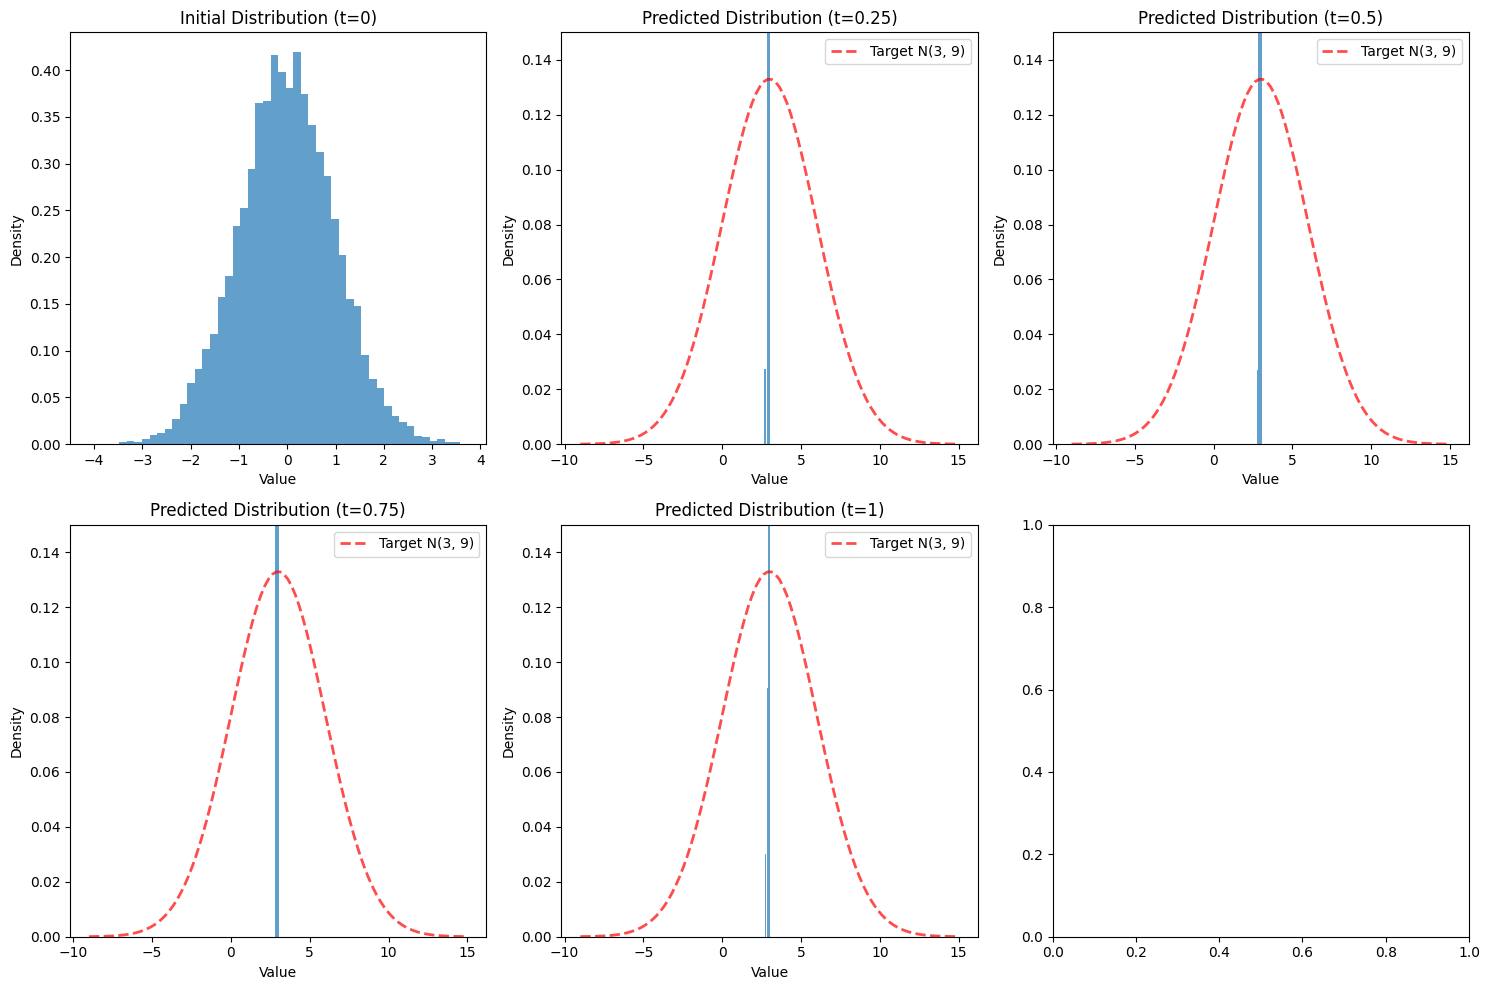

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

class Transport(nn.Module):
    def __init__(self):
        super(Transport, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# Create model and optimizer
model = Transport()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, verbose=True)

# Target distribution parameters
target_mean = 3
target_std = 3

# Training loop
num_epochs = 30000
batch_size = 1000

for epoch in range(num_epochs):
    x0 = torch.randn(batch_size, 1)
    t = torch.rand(batch_size, 1)
    
    # Generate target samples from N(3, 9)
    target = torch.normal(mean=target_mean, std=target_std, size=(batch_size, 1))
    
    output = model(x0, t)
    
    # Use KL divergence as loss
    output_std = output.std()
    output_mean = output.mean()
    kl_div = torch.log(target_std / output_std) + (output_std**2 + (output_mean - target_mean)**2) / (2 * target_std**2) - 0.5
    loss = kl_div + ((output - target) ** 2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate predictions for different time steps
num_samples = 10000
x0 = torch.randn(num_samples, 1)
time_steps = [0, 0.25, 0.5, 0.75, 1]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Plot initial distribution
axs[0].hist(x0.numpy(), bins=50, density=True, alpha=0.7)
axs[0].set_title('Initial Distribution (t=0)')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')

# Plot predictions for different time steps
for i, t in enumerate(time_steps[1:], 1):
    t_tensor = torch.full((num_samples, 1), t)
    with torch.no_grad():
        x_t = model(x0, t_tensor).numpy().flatten()
    
    axs[i].hist(x_t, bins=100, density=True, alpha=0.7)
    axs[i].set_title(f'Predicted Distribution (t={t})')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
    
    # Plot the target normal distribution
    x = np.linspace(target_mean - 4*target_std, target_mean + 4*target_std, 100)
    axs[i].plot(x, norm.pdf(x, target_mean, target_std), 'r--', lw=2, alpha=0.7, label='Target N(3, 9)')
    
    axs[i].legend()
    axs[i].set_ylim(0, 0.15)  # Set y-axis limit for better visualization

plt.tight_layout()
plt.show()